In [1]:
import pandas as pd

import math
import matplotlib
import numpy as np

# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

from ai import cs
from keras.layers import Reshape, Softmax
from scipy.fft import fft, ifft, fftfreq, dct, idct
from scipy import signal

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, AveragePooling2D, Embedding, LSTM, SimpleRNN
from keras.utils import np_utils

import random
import filterpy

In [2]:
input = open("data_noise_sinus/data_noise_sinus.txt").readlines()
input2 = open("data_noise_multitone/data_noise_multitone.txt").readlines()
input

['\n',
 '\n',
 '\n',
 '2022-12-02 22:20:21:565089  ->     Device used:genmet0\n',
 '\n',
 '2022-12-02 22:20:21:565089  ->     Theta   Phi             X              Y              Z                      |0>            |1>\n',
 '2022-12-02 22:20:21:628247  ->      36.0    56.9           0.3209906789   0.4923987072   0.8090169944           0.9510565163   0.1687547866 +0.2588693199 *i\n',
 '2022-12-02 22:20:22:180768  ->      35.6    48.9           0.3826732306   0.4386665601   0.8131007610           0.9521293927   0.2009565262 +0.2303607910 *i\n',
 '2022-12-02 22:20:22:733142  ->      38.3    26.6           0.5541780472   0.2775116939   0.7847763705           0.9446630009   0.2933204998 +0.1468839648 *i\n',
 '2022-12-02 22:20:23:284986  ->      38.7    60.6           0.3069339669   0.5447200375   0.7804304073           0.9435121640   0.1626550132 +0.2886661446 *i\n',
 '2022-12-02 22:20:23:840155  ->      38.1    38.2           0.4849018958   0.3815801654   0.7869350220           0.945234

In [3]:
def parse_line(line: str):
    strings = [x for x in line.split(" ") if x != "" and x != "->"][0:-1]
    strings = [float(x) if i > 1 else x for i, x in enumerate(strings)]
    datetime_str = strings[0] + 'T' + strings[1]
    datetime_str = datetime_str[:19] + "." + datetime_str[20:]
    strings = [pd.Timestamp(datetime_str)] + strings[2:]
    return strings


columns = ['datetime', 'Theta', 'Phi', 'X', 'Y', 'Z', '|0>', '|1> r', '|1> i']
data = [parse_line(l) for l in input[6:]]
data2 = [parse_line(l) for l in input2[6:]]

In [4]:
df = pd.DataFrame(data, columns=columns)
df2 = pd.DataFrame(data2, columns=columns)
df

,datetime,Theta,Phi,X,Y,Z,|0>,|1> r,|1> i
0,2022-12-02 22:20:21.628247,36.0,56.9,0.320991,0.492399,0.809017,0.951057,0.168755,0.258869
1,2022-12-02 22:20:22.180768,35.6,48.9,0.382673,0.438667,0.813101,0.952129,0.200957,0.230361
2,2022-12-02 22:20:22.733142,38.3,26.6,0.554178,0.277512,0.784776,0.944663,0.293320,0.146884
3,2022-12-02 22:20:23.284986,38.7,60.6,0.306934,0.544720,0.780430,0.943512,0.162655,0.288666
4,2022-12-02 22:20:23.840155,38.1,38.2,0.484902,0.381580,0.786935,0.945234,0.256498,0.201844
...,...,...,...,...,...,...,...,...,...
8699,2022-12-02 23:40:26.075369,38.7,61.0,0.303124,0.546850,0.780430,0.943512,0.160636,0.289795
8700,2022-12-02 23:40:26.627850,38.8,40.3,0.477891,0.405281,0.779338,0.943223,0.253329,0.214838
8701,2022-12-02 23:40:27.180213,42.9,31.1,0.582879,0.351615,0.732543,0.930737,0.313128,0.188891
8702,2022-12-02 23:40:27.732510,39.6,62.5,0.294330,0.565402,0.770513,0.940881,0.156412,0.300464


In [5]:
deltas = [(df["datetime"][i+1]-df["datetime"][i]).total_seconds()  for i in range(df.shape[0]-2, 0, -1)]
average_delta = sum(deltas)/len(deltas)
average_delta

0.5522987566076781

In [6]:
df["datetime"][1] - df["datetime"][0]

Timedelta('0 days 00:00:00.552521')

In [7]:
class Filter:
    def filter_1d_array(self, array):
        raise NotImplemented


class EmptyFilter(Filter):
    def filter_1d_array(self, array):
        return array


class IIR(Filter):
    def __init__(self, r: float, start=None):
        self.r = r
        self.start = start

    def filter_1d_array(self, array):
        output = []
        if self.start is None:
            x = array[0]
        else:
            x = self.start
        for i in range(len(array)):
            x = self.r * x + (1 - self.r) * array[i]
            output.append(x)
        return output


class RunningAverage(Filter):
    def __init__(self, width: int):
        self.width = width

    def filter_1d_array(self, array):
        f = np.array([1 for _ in range(self.width)])
        return signal.convolve(f, array)


class Gaussian(Filter):
    def __init__(self, width: int, std_dev: float):
        self.width = width
        self.std_dev = std_dev

    def filter_1d_array(self, array):
        f = signal.windows.gaussian(self.width, self.std_dev)
        return signal.convolve(f, array)



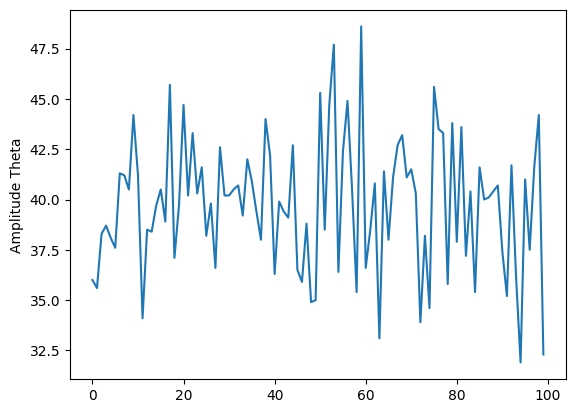

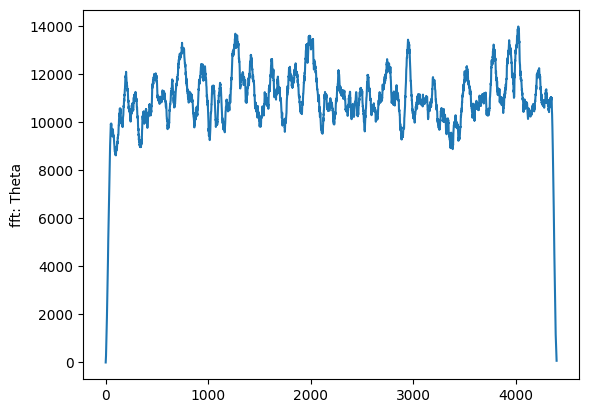

Average: 39.60754825367656
Average absolute deviation: 2.7356815087341504
std dev: 3.38896847376098
x with highest y in fft 4026


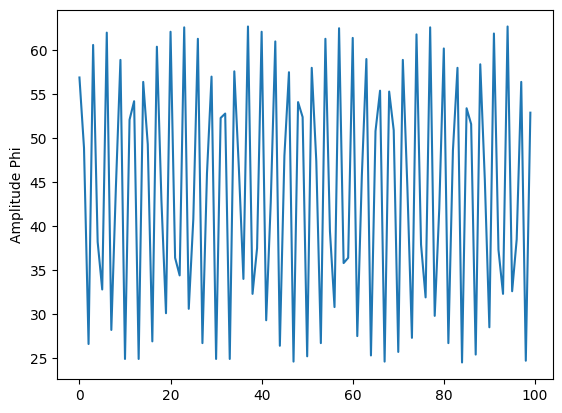

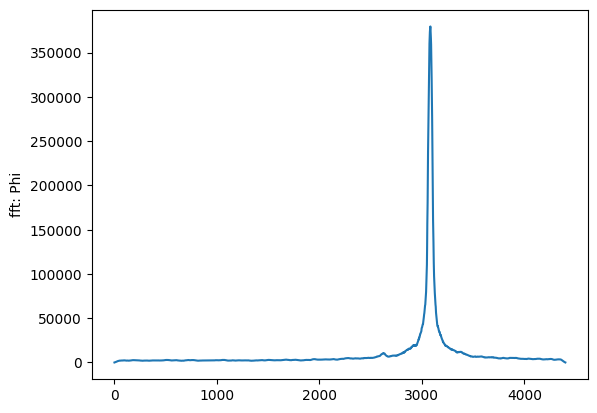

Average: 44.034673713235236
Average absolute deviation: 12.223820384728402
std dev: 13.556267778382004
x with highest y in fft 3083


[None, None]

In [8]:
def plot_with_fft(amplitude, name):
    avg = sum(amplitude) / len(amplitude)
    amplitude_offseted = list(map(lambda x: x - avg, amplitude))
    amplitude_fft = fft(amplitude_offseted)
    amplitude_fft_amplitude = np.sqrt(np.real(amplitude_fft) ** 2 + np.imag(amplitude_fft) ** 2)
    # N =len(amplitude_fft_amplitude)
    # xf = fftfreq(N, average_delta)[:N//2]
    amplitude_fft_amplitude = amplitude_fft_amplitude[0:len(amplitude_fft_amplitude) // 2]
    # f = IIR(0.9975)
    # f = RunningAverage(1)
    f = Gaussian(50, 20)
    amplitude_fft_real_filtered = f.filter_1d_array(amplitude_fft_amplitude)

    plt.plot(amplitude[:100])
    plt.ylabel(f"Amplitude {name}")
    plt.show()

    plt.plot(amplitude_fft_real_filtered)
    plt.ylabel(f"fft: {name}")
    plt.show()

    abs_dev = [abs(a - avg) for a in amplitude]
    square_dev = [(a - avg)**2 for a in amplitude]
    print(f"Average: {avg}")
    print(f"Average absolute deviation: {sum(abs_dev) / len(abs_dev)}")
    print(f"std dev: {math.sqrt(sum(square_dev) / len(square_dev))}")
    max_x = max(enumerate(amplitude_fft_real_filtered), key=lambda x: x[1])[0]
    print(f"x with highest y in fft {max_x}")


[plot_with_fft([d[i] for d in data], df.columns[i]) for i in range(1, 3)]
# [plot_fft([d[i] for d in data], df.columns[i]) for i in range(1, 9)]

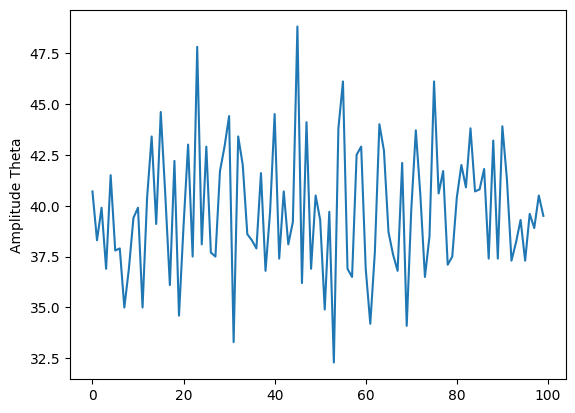

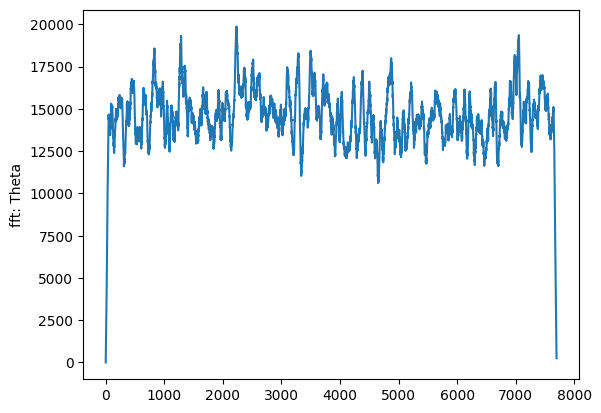

Average: 39.63496699993464
Average absolute deviation: 2.7382034272354545
std dev: 3.389891982154974
x with highest y in fft 2233


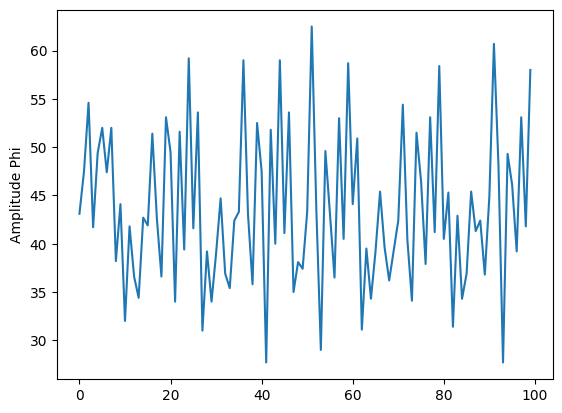

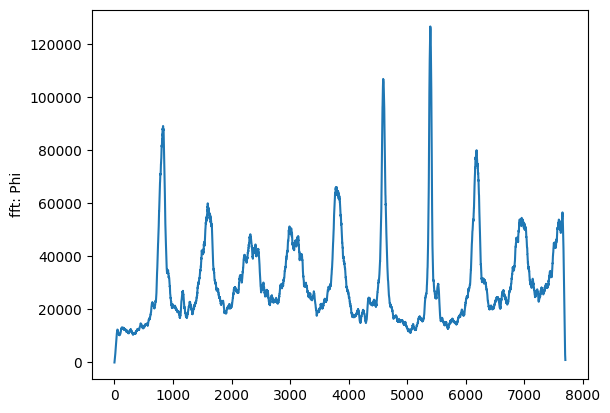

Average: 43.17478272234202
Average absolute deviation: 6.40186119665678
std dev: 8.008529476773695
x with highest y in fft 5393


[None, None]

In [9]:
[plot_with_fft([d[i] for d in data2], df.columns[i]) for i in range(1, 3)]

### AAaaAAaAa

In [10]:
class Oscillation:
    def __init__(self, freq, ampl) -> None:
        self.freq = freq
        self.ampl = ampl

    def angle_offsets(self, time):
        return math.sin(time * self.freq) * self.ampl, math.cos(time * self.freq) * self.ampl


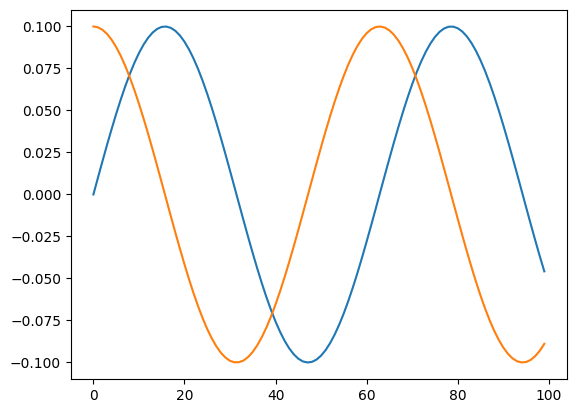

In [11]:
oscillation = Oscillation(10, 0.1)

thetas = [oscillation.angle_offsets(t*0.01)[0] for t in range(100)]
phis = [oscillation.angle_offsets(t*0.01)[1] for t in range(100)]

plt.plot(thetas)
plt.plot(phis)
plt.show()

In [12]:
[d[2] for d in data][:10]

[56.9, 48.9, 26.6, 60.6, 38.2, 32.8, 62.0, 28.2, 44.4, 58.9]

In [13]:
oscillation = Oscillation(0.5, 1.5)
# oscillation = Oscillation(5, 1.5)
# oscillation = Oscillation(0.05, 1.5)

In [14]:
def prepare_raw_data(data):
    theta_offsets = [oscillation.angle_offsets(t)[0] for t in range(len(data))]
    phi_offsets = [oscillation.angle_offsets(t)[1] for t in range(len(data))]

    thetas = [d[1] + t for d, t in zip(data, theta_offsets)]
    phis = [d[2] + t for d, t in zip(data, phi_offsets)]

    return theta_offsets, phi_offsets, thetas, phis

theta_offsets, phi_offsets, thetas, phis = prepare_raw_data(data)

print(theta_offsets[:5])
print(phi_offsets[:5])

[0.0, 0.7191383079063045, 1.2622064772118446, 1.4962424799060816, 1.3639461402385225]
[1.5, 1.3163738428355591, 0.8104534588022096, 0.10610580250155435, -0.6242202548207136]


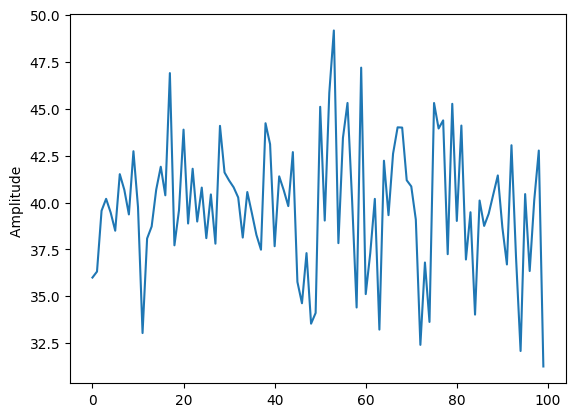

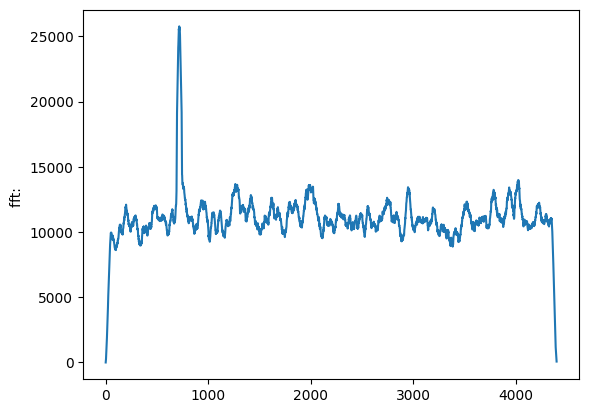

Average: 39.60816419986725
Average absolute deviation: 2.865561144911033
std dev: 3.5584493996514013
x with highest y in fft 718


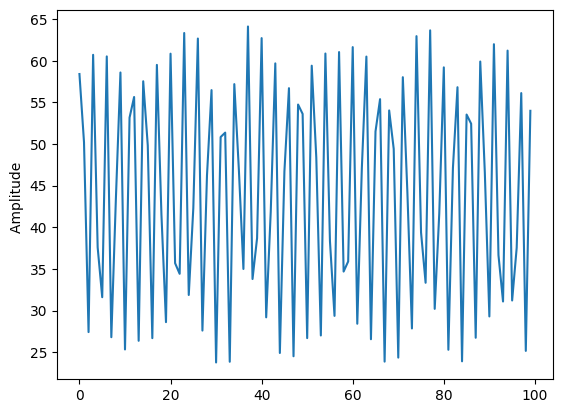

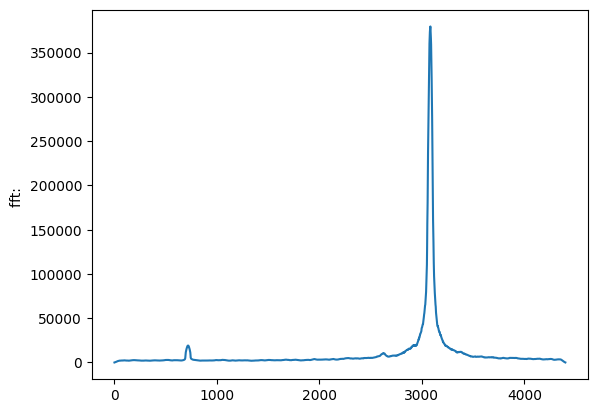

Average: 44.03455072139424
Average absolute deviation: 12.24382502594039
std dev: 13.598223926015347
x with highest y in fft 3083


[None, None]

In [15]:
[plot_with_fft(x, "") for x in [thetas, phis] ]
# [plot_with_fft(x, "") for x in [theta_offsets, phi_offsets] ]

In [16]:
window_size = 20

def into_windows(array, window_len):
    N = len(array)
    output = []
    for i in range(N - window_len + 1):
        output.append(array[i:i + window_len])
    return np.array(output)

def create_train_data(phis, phi_offsets, window_size):
    N = len(phis)
    xs_train = phis[:int(N * 0.7)]
    xs_test = phis[int(N * 0.7):]
    ys_train = phi_offsets[:int(N * 0.7)]
    ys_test = phi_offsets[int(N * 0.7):]
    ys_train = [y + 44 for y in ys_train]
    ys_test = [y + 44 for y in ys_test]

    xs_windowed_train = into_windows(xs_train, window_size)
    xs_windowed_test = into_windows(xs_test, window_size)
    xs_windowed_train /= 90
    xs_windowed_test /= 90

    ys_windowed_train = into_windows(ys_train, window_size)
    ys_windowed_test = into_windows(ys_test, window_size)
    ys_windowed_train /= 90
    ys_windowed_test /= 90

    ys_train_last_in_window = np.array([x[-1] for x in ys_windowed_train])
    ys_test_last_in_window = np.array([x[-1] for x in ys_windowed_test])

    return xs_train, xs_test, ys_train, ys_test, xs_windowed_train, xs_windowed_test, ys_windowed_train, ys_windowed_train, ys_train_last_in_window, ys_test_last_in_window


xs_train, xs_test, ys_train, ys_test, xs_windowed_train, xs_windowed_test, ys_windowed_train, ys_windowed_train, ys_train_last_in_window, ys_test_last_in_window = create_train_data(phis, phi_offsets, window_size)

In [17]:
xs_test

[25.536008044916393,
 60.49573830244852,
 46.1116770959539,
 28.78198810240984,
 63.48945673525386,
 37.30570487555385,
 35.17365533762221,
 61.6725393794648,
 28.57401463991243,
 40.20013736186565,
 59.49347876717237,
 25.906702136796277,
 46.914152490562664,
 58.64262130867587,
 26.113754018223567,
 53.48771741295887,
 56.79743569904316,
 25.665012988727852,
 57.59632144276738,
 47.65508007304585,
 25.022770618567623,
 58.15420448635213,
 35.93961951975896,
 33.382586627278634,
 62.099135499594276,
 32.93831346986938,
 39.119143991247626,
 63.37493600730109,
 30.294095736197594,
 47.347448720462445,
 60.09538275166301,
 24.973062832935156,
 49.15733807217132,
 54.72344285258017,
 23.00209334416436,
 53.147483626418065,
 50.724017087582226,
 25.215021716678365,
 58.85131548087481,
 46.45262798755351,
 29.971736963572702,
 63.23051340228827,
 39.639050269224605,
 32.69319139210974,
 62.25106554917723,
 32.694371029320536,
 36.88388955402264,
 60.72012130447842,
 27.418678972171726,
 44

In [18]:
ys_train

[45.5,
 45.31637384283556,
 44.81045345880221,
 44.10610580250155,
 43.37577974517929,
 42.7982845766796,
 42.51501125509933,
 42.59531496906381,
 43.01953456870458,
 43.68380630085383,
 44.42549327819484,
 45.06300466143689,
 45.44025542997555,
 45.46488143859204,
 45.13085338151496,
 44.51995297675254,
 43.78174994928708,
 43.09698214597277,
 42.63330460717299,
 42.50424176570543,
 42.74139270638532,
 43.28669460800601,
 44.006638546982074,
 44.72495713812951,
 45.265780938098736,
 45.49669741876787,
 45.36117017217529,
 44.89238099496484,
 44.20510582731175,
 43.46761359981694,
 42.860468130711766,
 42.53231980577167,
 42.56351077951492,
 42.94640441374593,
 43.5872549929226,
 44.32915994481719,
 44.99047506236612,
 45.409287340622384,
 45.48305692728,
 45.19372245472091,
 44.61212309272009,
 43.88065464908219,
 43.1784061096636,
 42.67731240868801,
 42.500058760408045,
 42.690043039859724,
 43.2007504694999,
 43.90714205900837,
 44.6362685110055,
 45.20961424086838,
 45.48680421779

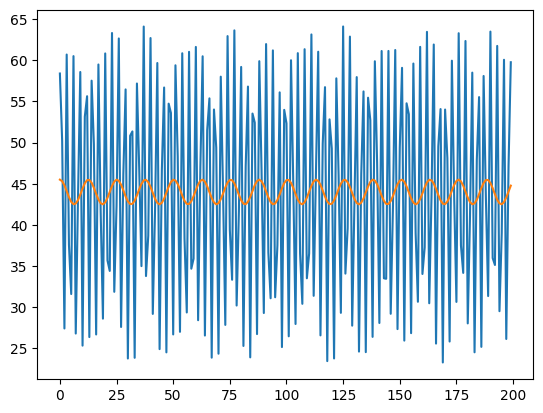

In [19]:
plt.plot(xs_train[:200])
plt.plot(ys_train[:200])
plt.show()

In [20]:
max(ys_train) - min(ys_train)

2.99999999931849

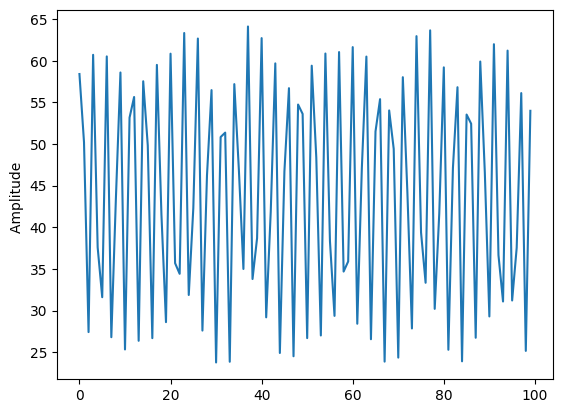

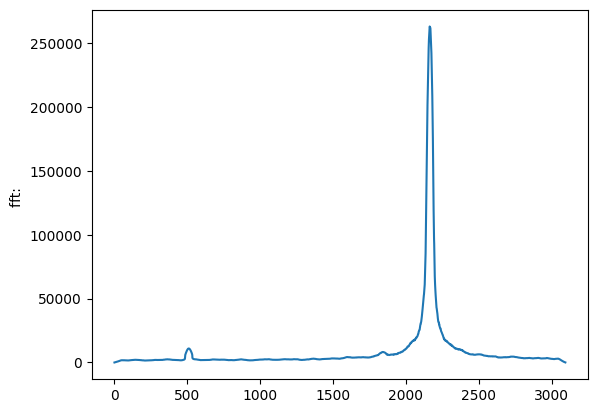

Average: 44.02664468143576
Average absolute deviation: 12.247021226067176
std dev: 13.599114243083722
x with highest y in fft 2163


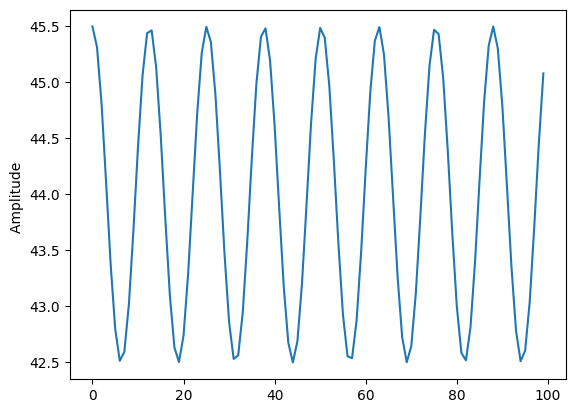

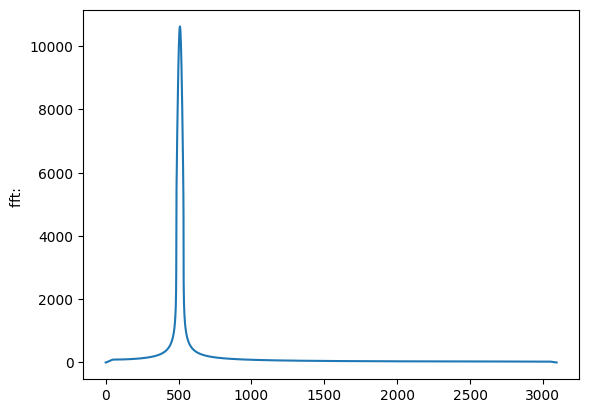

Average: 43.99962564006986
Average absolute deviation: 0.9549785046912261
std dev: 1.0607080017025596
x with highest y in fft 509


[None, None]

In [21]:
[plot_with_fft(x, "") for x in[xs_train, ys_train]]

## Windowed input and single output dense

In [22]:
def get_dense_model():
    model = Sequential()
    model.add(Dense(256, input_shape=(window_size,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))  # Dropout helps protect the model from memorizing or "overfitting" the training data

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model
model = get_dense_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5376      
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 activation_1 (Activation)   (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 6

In [23]:
model.fit(xs_windowed_train, ys_train_last_in_window,
          batch_size=1024, epochs=128,
          verbose=1,
          validation_data=(xs_windowed_test, ys_test_last_in_window))

Epoch 1/128
6/6 [==============================] - 1s 38ms/step - loss: 0.1092 - root_mean_squared_error: 0.3304 - val_loss: 0.0680 - val_root_mean_squared_error: 0.2607
Epoch 2/128
6/6 [==============================] - 0s 11ms/step - loss: 0.0388 - root_mean_squared_error: 0.1970 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0868
Epoch 3/128
6/6 [==============================] - 0s 12ms/step - loss: 0.0311 - root_mean_squared_error: 0.1764 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0725
Epoch 4/128
6/6 [==============================] - 0s 12ms/step - loss: 0.0170 - root_mean_squared_error: 0.1305 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0653
Epoch 5/128
6/6 [==============================] - 0s 13ms/step - loss: 0.0168 - root_mean_squared_error: 0.1298 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0385
Epoch 6/128
6/6 [==============================] - 0s 12ms/step - loss: 0.0125 - root_mean_squared_error: 0.1118 - val_loss: 0.0014 - val_root_mean_sq

In [24]:
def evaluate(model, xs_windowed_test, ys, plot_range = 200):
    eval_results = model.evaluate(xs_windowed_test, ys,verbose=0)
    pred = model.predict(xs_windowed_test)

    print(f"{xs_windowed_test[0][-1]} {model.predict(xs_windowed_test, verbose=0)}")
    print({k:v for k, v in zip(model.metrics_names, eval_results)})

    plt.plot([x[-1] for x in xs_windowed_test[:plot_range]])
    plt.plot(pred[:plot_range])
    plt.plot(ys[:plot_range])
    plt.show()

    plt.plot(pred[:plot_range])
    plt.plot(ys[:plot_range])
    plt.show()

82/82 [==============================] - 0s 635us/step
0.5295008897005095 [[0.47302955]
 [0.4687869 ]
 [0.4621417 ]
 ...
 [0.46605864]
 [0.46796763]
 [0.46780282]]
{'loss': 0.0002958977420348674, 'root_mean_squared_error': 0.017201678827404976}


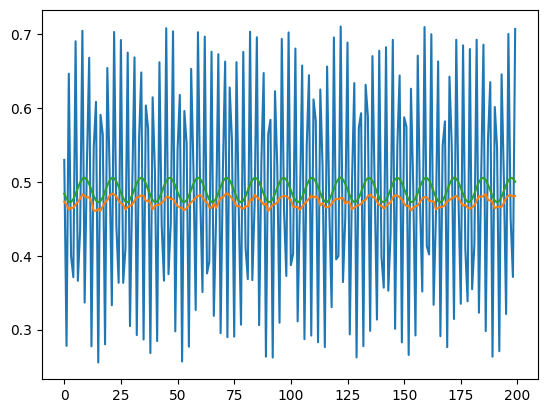

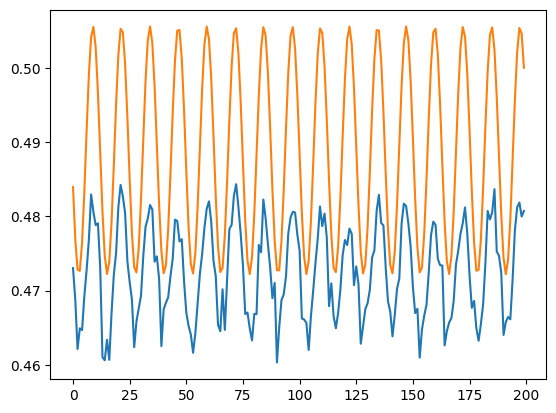

In [25]:
evaluate(model, xs_windowed_test, ys_test_last_in_window)

## Windowed input and single output RNN

In [26]:
def get_rnn_model(window_size = window_size):
    model = Sequential()
    # model.add(SimpleRNN((window_size,), input_shape=(window_size,),
    #                     activation="relu"))
    # model.add(Dense(units=1, activation="relu"))
    model.add(SimpleRNN(32, input_shape=(window_size,1)))
    # model.add(LSTM(32, input_shape=(window_size,1)))
    # model.add(LSTM(128, input_shape=(window_size,1), return_sequences=True))

    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5376      
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 activation_1 (Activation)   (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 6

In [27]:
model.fit(xs_windowed_train, ys_train_last_in_window,
          batch_size=1024, epochs=128,
          verbose=1,
          validation_data=(xs_windowed_test, ys_test_last_in_window))

Epoch 1/128
6/6 [==============================] - 0s 16ms/step - loss: 0.0020 - root_mean_squared_error: 0.0443 - val_loss: 4.0681e-04 - val_root_mean_squared_error: 0.0202
Epoch 2/128
6/6 [==============================] - 0s 12ms/step - loss: 0.0020 - root_mean_squared_error: 0.0449 - val_loss: 2.5797e-04 - val_root_mean_squared_error: 0.0161
Epoch 3/128
6/6 [==============================] - 0s 11ms/step - loss: 0.0020 - root_mean_squared_error: 0.0445 - val_loss: 3.1961e-04 - val_root_mean_squared_error: 0.0179
Epoch 4/128
6/6 [==============================] - 0s 11ms/step - loss: 0.0020 - root_mean_squared_error: 0.0445 - val_loss: 3.0008e-04 - val_root_mean_squared_error: 0.0173
Epoch 5/128
6/6 [==============================] - 0s 11ms/step - loss: 0.0020 - root_mean_squared_error: 0.0445 - val_loss: 3.0536e-04 - val_root_mean_squared_error: 0.0175
Epoch 6/128
6/6 [==============================] - 0s 12ms/step - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 2.405

82/82 [==============================] - 0s 680us/step
0.5295008897005095 [[0.4813053 ]
 [0.47508323]
 [0.4738242 ]
 ...
 [0.4761597 ]
 [0.47526821]
 [0.47345933]]
{'loss': 3.068692603847012e-05, 'root_mean_squared_error': 0.005539577919989824}


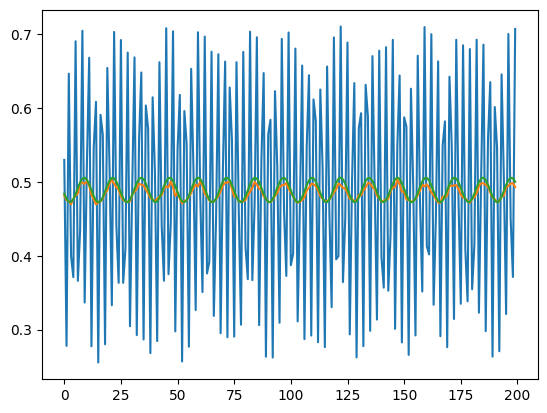

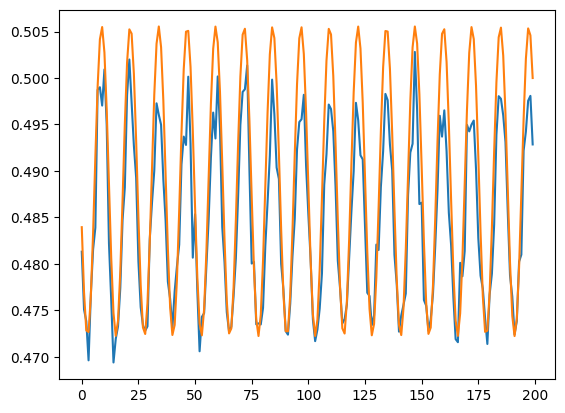

In [28]:
evaluate(model, xs_windowed_test, ys_test_last_in_window)

# Harder data

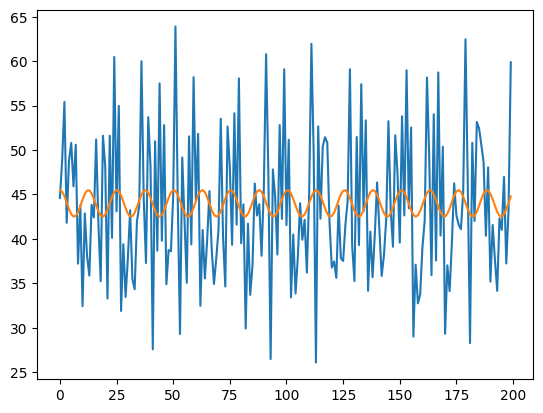

In [29]:
theta_offsets, phi_offsets, thetas, phis = prepare_raw_data(data2)
xs_train, xs_test, ys_train, ys_test, xs_windowed_train, xs_windowed_test, ys_windowed_train, ys_windowed_train, ys_train_last_in_window, ys_test_last_in_window = create_train_data(phis, phi_offsets, window_size)
plt.plot(xs_train[:200])
plt.plot(ys_train[:200])
plt.show()

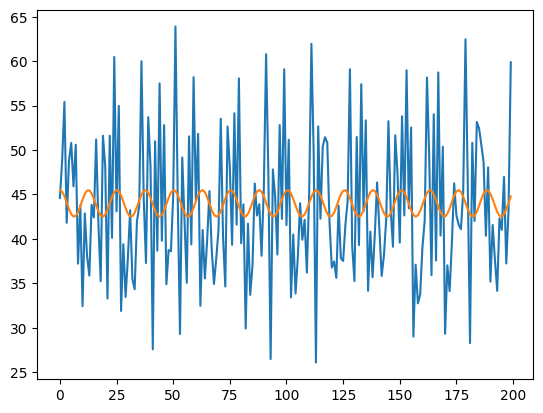

In [30]:
plt.plot(xs_train[:200])
plt.plot(ys_train[:200])
plt.show()

In [33]:
def run_model(model, plot_range = 200):
    model.fit(xs_windowed_train, ys_train_last_in_window,
              batch_size=1024, epochs=128,
              verbose=0,
              validation_data=(xs_windowed_test, ys_test_last_in_window))
    evaluate(model, xs_windowed_test, ys_test_last_in_window, plot_range)

143/143 [==============================] - 0s 619us/step
0.56682228588215 [[0.4870813 ]
 [0.48444527]
 [0.48886466]
 ...
 [0.48488575]
 [0.48788655]
 [0.48908395]]
{'loss': 0.00011729113612091169, 'root_mean_squared_error': 0.010830103419721127}


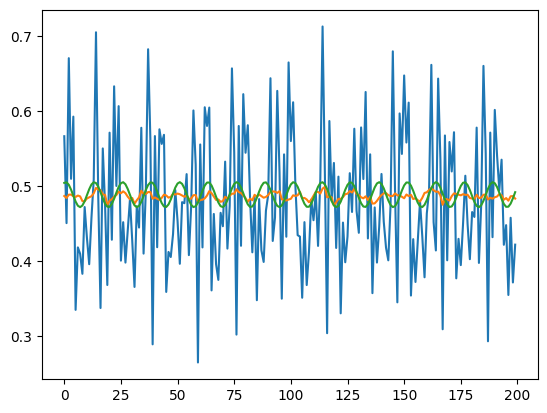

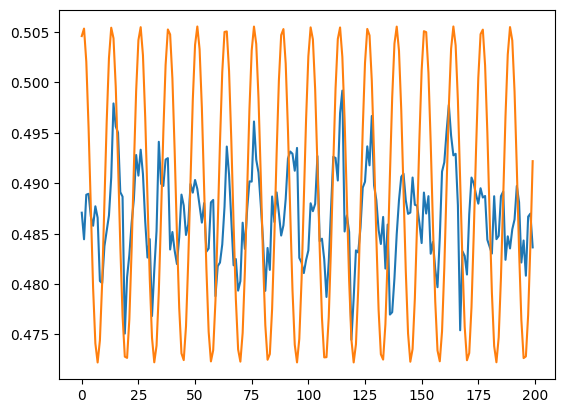

143/143 [==============================] - 0s 1ms/step
0.56682228588215 [[0.48767006]
 [0.48733523]
 [0.49036083]
 ...
 [0.48992077]
 [0.49421135]
 [0.49769327]]
{'loss': 0.0001277097180718556, 'root_mean_squared_error': 0.011300872080028057}


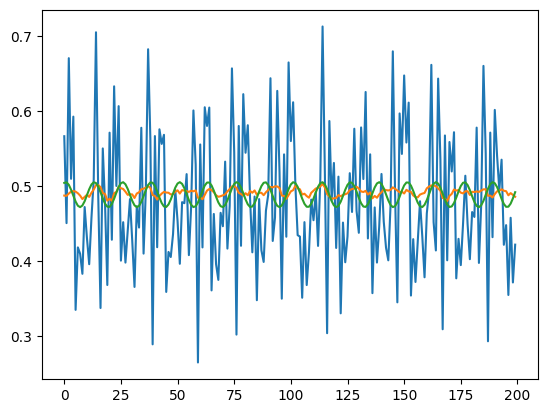

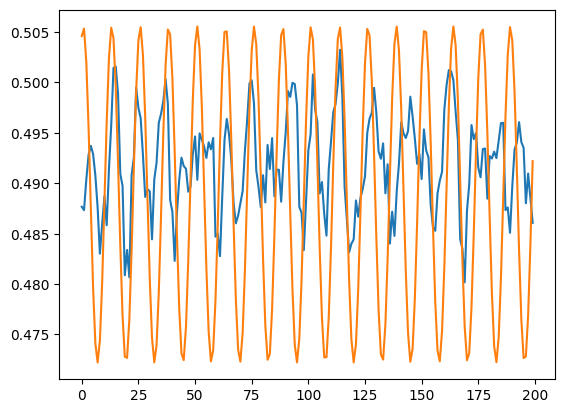

In [34]:
run_model(get_dense_model())
run_model(get_rnn_model())

# Low freq

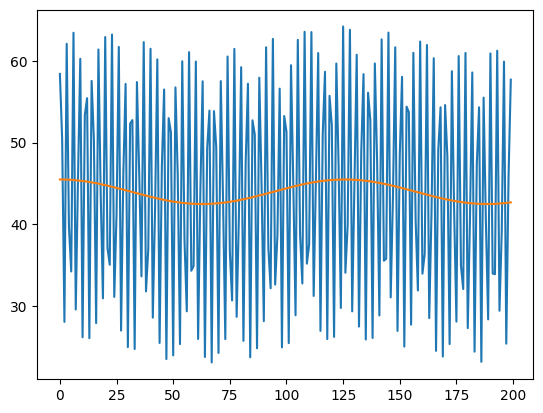

In [35]:
oscillation = Oscillation(0.05, 1.5)
theta_offsets, phi_offsets, thetas, phis = prepare_raw_data(data)
# theta_offsets, phi_offsets, thetas, phis = prepare_raw_data(data2)
xs_train, xs_test, ys_train, ys_test, xs_windowed_train, xs_windowed_test, ys_windowed_train, ys_windowed_train, ys_train_last_in_window, ys_test_last_in_window = create_train_data(phis, phi_offsets, window_size)
plt.plot(xs_train[:200])
plt.plot(ys_train[:200])
plt.show()

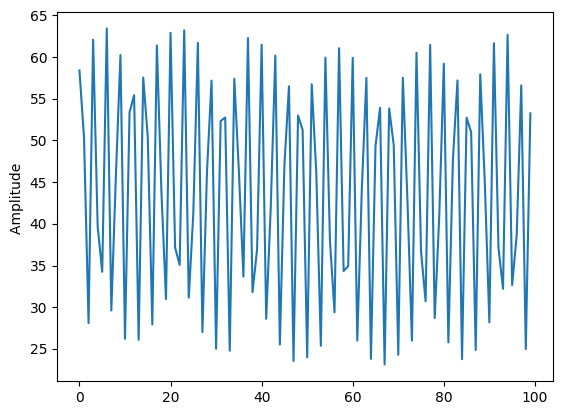

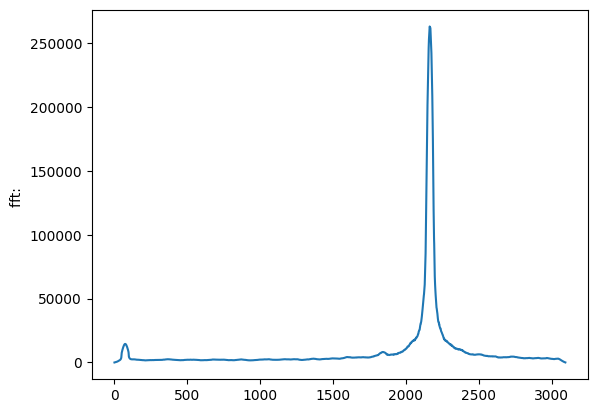

Average: 44.0279243040482
Average absolute deviation: 12.242899762946626
std dev: 13.599010473057842
x with highest y in fft 2163


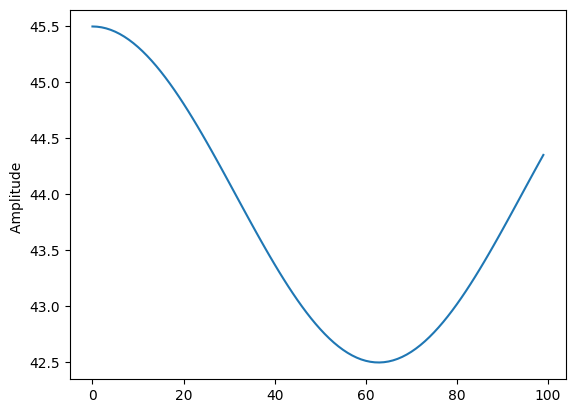

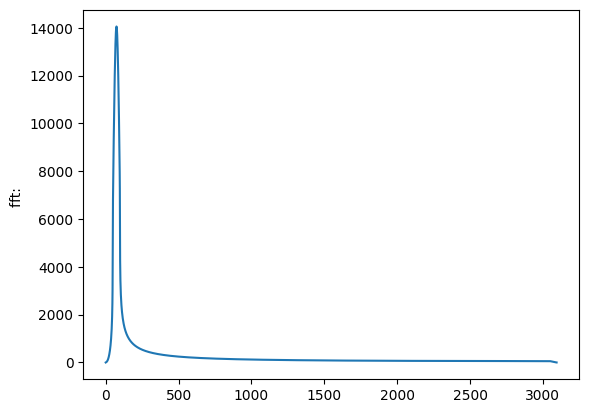

Average: 44.000905262682345
Average absolute deviation: 0.9546921809795447
std dev: 1.0604301795387308
x with highest y in fft 74


[None, None]

In [36]:
[plot_with_fft(x, "") for x in[xs_train, ys_train]]

82/82 [==============================] - 0s 778us/step
0.5230195232791284 [[0.4737838 ]
 [0.4700374 ]
 [0.47463912]
 ...
 [0.4774595 ]
 [0.48250645]
 [0.47768825]]
{'loss': 0.00020539172692224383, 'root_mean_squared_error': 0.014331494458019733}


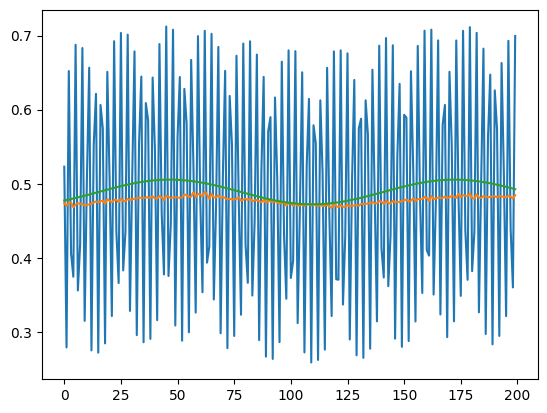

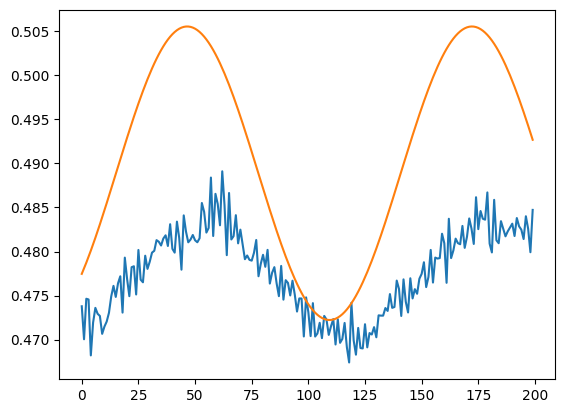

82/82 [==============================] - 0s 970us/step
0.5230195232791284 [[0.48418823]
 [0.4820646 ]
 [0.4824092 ]
 ...
 [0.48836344]
 [0.48879296]
 [0.48877606]]
{'loss': 4.245387390255928e-05, 'root_mean_squared_error': 0.006515663582831621}


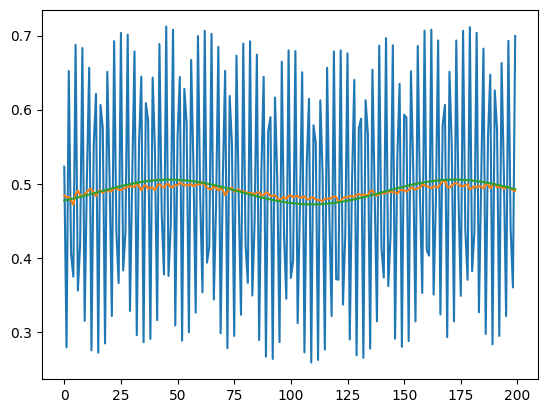

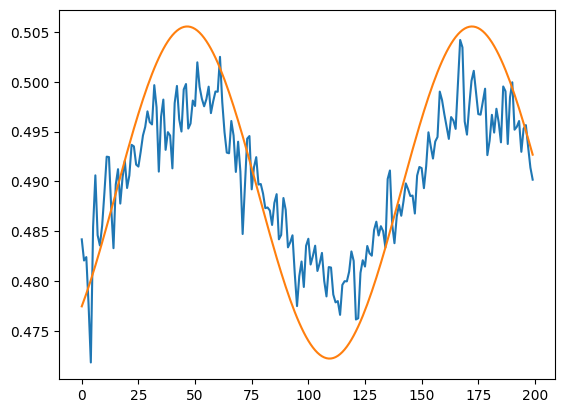

In [37]:
run_model(get_dense_model())
run_model(get_rnn_model())

# High freq

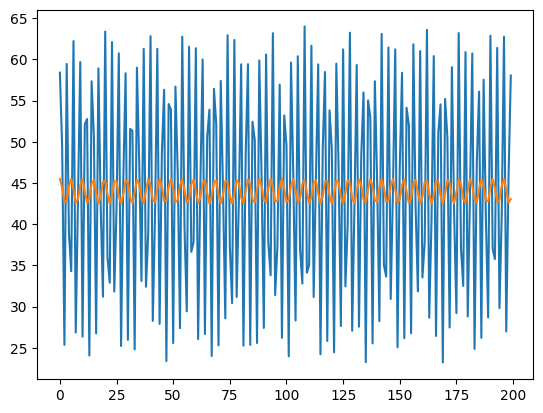

In [38]:
oscillation = Oscillation(5, 1.5)
theta_offsets, phi_offsets, thetas, phis = prepare_raw_data(data)
# theta_offsets, phi_offsets, thetas, phis = prepare_raw_data(data2)
xs_train, xs_test, ys_train, ys_test, xs_windowed_train, xs_windowed_test, ys_windowed_train, ys_windowed_train, ys_train_last_in_window, ys_test_last_in_window = create_train_data(phis, phi_offsets, window_size)
plt.plot(xs_train[:200])
plt.plot(ys_train[:200])
plt.show()

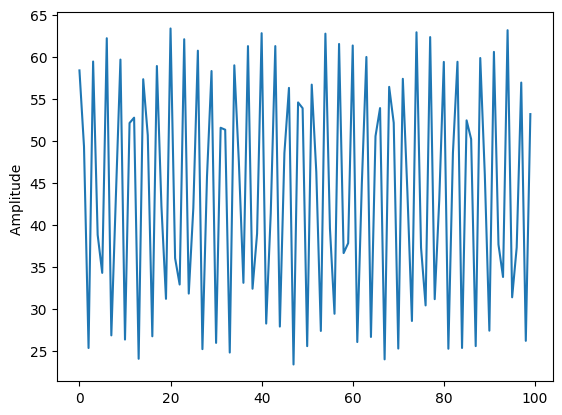

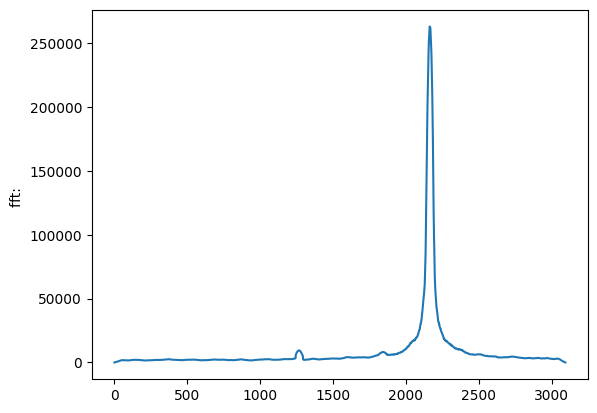

Average: 44.027191206831354
Average absolute deviation: 12.254557653033382
std dev: 13.600201150966194
x with highest y in fft 2163


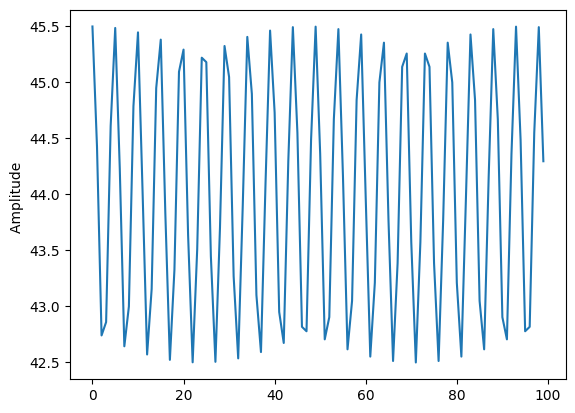

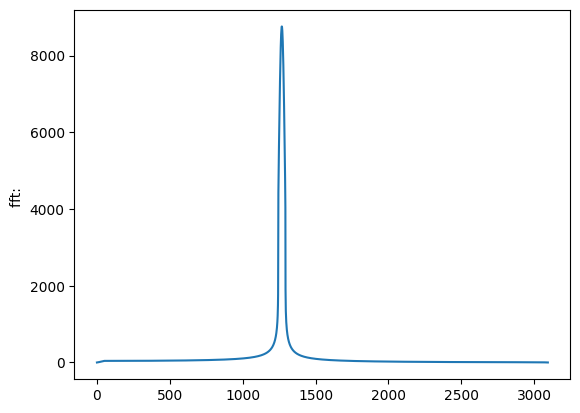

Average: 44.000172165465585
Average absolute deviation: 0.9550674695992957
std dev: 1.060724705842841
x with highest y in fft 1269


[None, None]

In [39]:
[plot_with_fft(x, "") for x in[xs_train, ys_train]]

82/82 [==============================] - 0s 652us/step
0.550970154299736 [[0.48189205]
 [0.47478676]
 [0.4600407 ]
 ...
 [0.4803856 ]
 [0.47215408]
 [0.46760768]]
{'loss': 0.00038009515265002847, 'root_mean_squared_error': 0.019496029242873192}


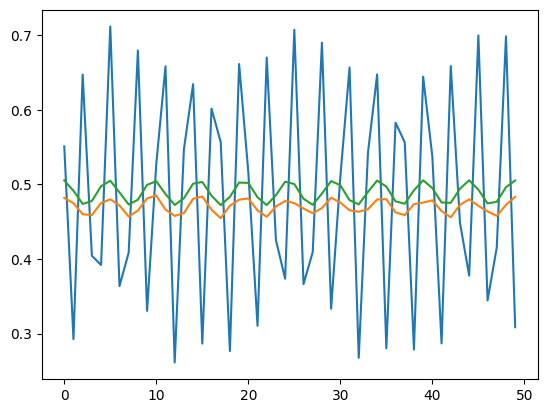

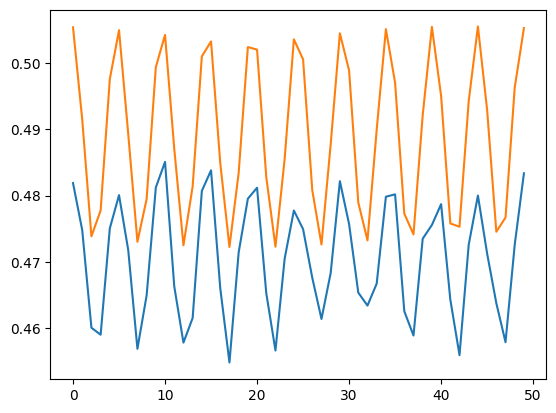

82/82 [==============================] - 0s 977us/step
0.550970154299736 [[0.4925555 ]
 [0.49027187]
 [0.48315066]
 ...
 [0.4996446 ]
 [0.49758813]
 [0.48282066]]
{'loss': 7.315591210499406e-05, 'root_mean_squared_error': 0.008553123101592064}


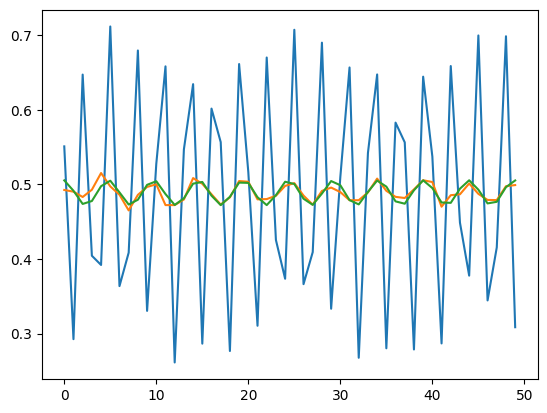

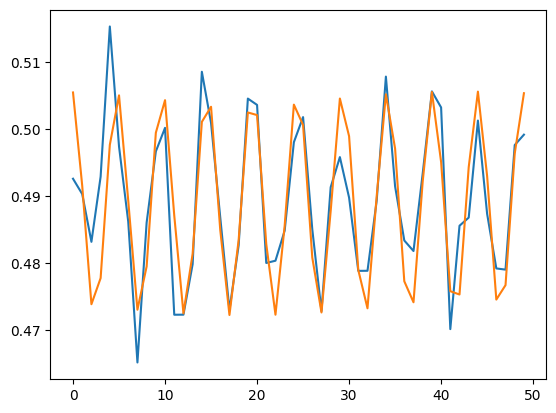

In [40]:
run_model(get_dense_model(), 50)
run_model(get_rnn_model(), 50)